In [3]:
import matplotlib.pyplot as plt

def draw(V, adj_V, color='b'):  
  # draw vertices
  plt.plot(V[:,0], V[:,1], '{}o'.format(color))
  for i in range(len(V)):
    # add vertex labels
    plt.text(V[i,0] + 0.01, V[i,1] + 0.01, i)
  
  # draw edges]
  for i in range(len(V)):
    v = V[i]
    for j in adj_V[i]:
      w = V[j]
      xs = [v[0], w[0]]
      ys = [v[1], w[1]]
      plt.plot(xs, ys, '{}-'.format(color))
  plt.show()
  
def bfs(v, adj_V):
  vis = [v]
  vis.extend(adj_V[v])
  q = list(adj_V[v])
  while len(q) > 0:
    w = q.pop(0)
    for u in adj_V[w]:
      if u not in vis:
        vis.append(u)
        q.append(u)
  return vis

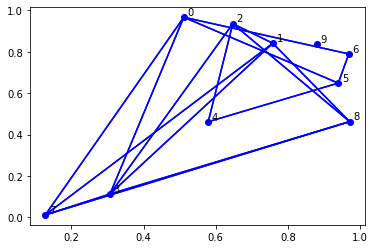

In [4]:
import numpy as np

V = np.random.rand(10, 2)

# create random adjacency list
adj_V = {}
for i in range(len(V)):
  adj = np.random.randint(0, len(V) - 1, np.random.randint(0, 5))
  adj = adj[adj != i]
  adj = list(set(adj))
  adj_V[i] = adj
  
# make adjacency list symmetric
for i in range(len(V)):
  for nbr in adj_V[i]:
    if i not in adj_V[nbr]:
      adj_V[nbr].extend([i])
      
draw(V, adj_V)

# EE Repulsion
By Lin, Yen (2012) with slight alteration.

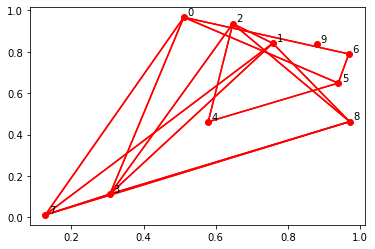

Angular resolution: 0.006138276154652497


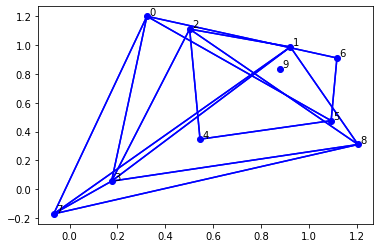

Angular resolution: 0.03056106664651085


In [5]:
from math import sqrt, pi
import numpy as np
from itertools import combinations

def get_angular_res(V, adj_V):
  ret = []
  for i in range(len(V)):
    if len(adj_V[i]) < 2:
      continue
    v = V[i]
    nbr_order = get_nbr_order(v, adj_V[i])
    for j in range(0, len(nbr_order)):
      k = (j + 1) % len(nbr_order)
      u = V[nbr_order[j]]
      w = V[nbr_order[k]]
      a = get_angle(v, w, u)
      ret.append(a)
  ret = min(ret)
  return ret
  
def card(v):
  ret = np.power(v, 2)
  ret = np.sum(ret)
  ret = sqrt(ret)
  return ret

def d2(p, q):
  ret = (p[0] - q[0]) ** 2
  ret += (p[1] - q[1]) ** 2
  ret = sqrt(ret)
  return ret

def get_angle(v, w, u):
  '''
  Gets angle between vectors vu and vw.
  '''
  vu = np.subtract(u, v)
  vw = np.subtract(w, v)
  ret = np.arccos(np.dot(vu, vw) / (card(vu) * card(vw)))
  return ret

def get_nbr_order(v, adj_v):
  '''
  return the circular order of the neighbors of v starting
  from edge vu, where u is the neighbor indexed first in adj_v.
  '''
  u = V[adj_v[0]]
  vu = np.subtract(u, v)
  angs = [0] # initialize as first in the circular order
  for i in range(1, len(adj_v)):
    w = V[adj_v[i]]
    vw = np.subtract(w, v)
    # get angle between edges vu, vw
    ang = np.arccos(np.dot(vu, vw) / (card(vu) * card(vw)))
    if (vw[0] * vu[1] - vu[0] * vw[1]) <= 0:
      # if vu is the right vector of the angle,
      # calculate the outer angle
      ang = (2 * pi) - ang
    angs.append(ang)
  ret = np.argsort(angs)
  ret = [adj_v[idx] for idx in ret]
  return ret

def get_rep_force(v, u, w, C3, C4, C5):
  f_e = C3 * ((np.arctan(d2(v, u) / C4)) + (np.arctan(d2(v, w) / C4)))
  ang = get_angle(v, w, u)
  f_ang = C5 * (np.cos(ang / 2)) / (np.sin(ang / 2))
  ret = f_e + f_ang
  return ret

def get_spring_force(v, u, C1, C2):
  uv = np.subtract(u, v)
  ret = card(uv)
  ret /= C2
  ret = np.log(ret)
  ret *= C1
  ret *= (uv / card(uv))
  return ret

def ee_repulsion(V, adj_V):
  W = V.copy()
  F = np.zeros((len(V), 2))
  C1 = 1 
  C2 = 1
  C3 = 1
  C4 = 1
  C5 = 1
  C6 = 0.05 # set to higher value for more freedom of placement
  for i in range(len(V)):
    # calculate repulsive force
    if len(adj_V[i]) < 2:
      continue
    v = W[i]
    nbr_order = get_nbr_order(v, adj_V[i])
    for j in range(0, len(nbr_order)):
      k = (j + 1) % len(nbr_order)
      u = W[nbr_order[j]]
      w = W[nbr_order[k]]
#       print(i, nbr_order[j], nbr_order[k])

      vu = np.subtract(u, v)
      vu_u = np.divide(vu, card(vu))
      vw = np.subtract(w, v)
      
      u_m = vu / card(vu) + vw / card(vw) 
      u_m = u_m / card(u_m)
      u_f = np.dot([[0, 1], [-1, 0]], u_m)
      vu_left = True if ((u_m[0] * vu_u[1]) - (vu_u[0] * u_m[1])) > 0 else False
      if vu_left:
        # change repulsion direction outwards from vu, vw
        u_f = np.multiply(-1, u_f)
      F[nbr_order[j]] += u_f
      F[nbr_order[k]] -= u_f

  for i in range(len(V)):
    W[i] += C6 * F[i]
  return W
    
W = ee_repulsion(V, adj_V)

draw(V, adj_V, color='r')
print(f'Angular resolution: {get_angular_res(V, adj_V)}')
plt.clf()
draw(W, adj_V)
print(f'Angular resolution: {get_angular_res(W, adj_V)}')

# Force-directed edge-vertex repulsion

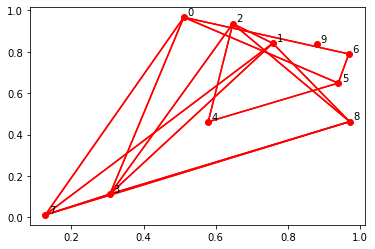

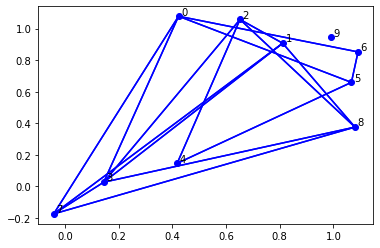

In [6]:
import numpy as np
import math

def is_left(p, q, r):
  # returns whether r is left of line pq
  s = (q[0] - p[0]) * (r[1] - p[1]) - (q[1] - p[1]) * (r[0] - [0])
  if s > 0:
    return True
  return False

def get_angle(v, w, u):
  '''
  Gets angle between vectors vu and vw.
  '''
  vu = np.subtract(u, v)
  vw = np.subtract(w, v)
  ret = np.arccos(np.dot(vu, vw) / (card(vu) * card(vw)))
  return ret
  
def ev_repulsion(V, adj_V, N=5, C1=1, C2=1, C3=1):
  W = V.copy()
  for a in range(N):
    F = np.subtract(V, W)
    F = np.multiply(C1, F)
    for i in range(len(V)):
      v = W[i]
      for j in range(len(V)):
        if i == j:
          continue
        w = W[j]
        for k in adj_V[j]:
          if i == k:
            continue
          u = W[k]
          vu = np.subtract(v, u)
          vw = np.subtract(v, w)
          vu_u = np.divide(vu, card(vu))
          vw_u = np.divide(vw, card(vw))
          bis = np.add(vu_u, vw_u)
          F_ang = np.divide(bis, card(bis))
          uw = np.subtract(u, w)
          uw = np.divide(uw, 2)
          uwu = (w - v) + uw
          F_mag = C2 / card(v - uwu)
          F[i] += (F_mag * F_ang)
    for i in range(len(V)):
      W[i] += np.multiply(C3, F[i])
  return W
      
draw(V, adj_V, 'r')
W = ev_repulsion(V, adj_V, N=10, C1=1, C2=1, C3=0.001)
draw(W, adj_V)

# Vertex-vertex repulsion (Birchfield & Overbye, 2018)

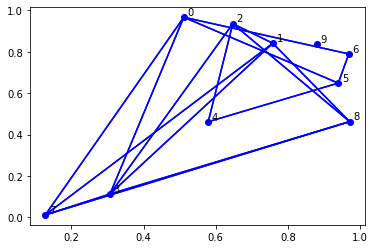

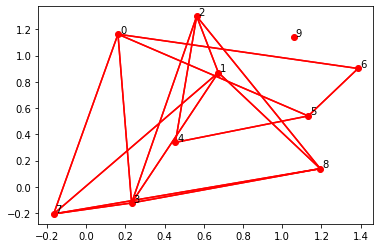

In [7]:
import algos.birchfield as bf
import algos
from importlib import reload

reload(algos.birchfield)
draw(V, adj_V, 'b')
W = bf.force_directed(V, adj_V, N=10, C1=2, C2=0.1, C3=0.1)
draw(W, adj_V, 'r')

# Frankenstein algorithm (Lin & Yen with Birchfield & Overbye)
Use the edge incident repulsion part of the algorithm from Lin & Yen and combine it with the part of the algorithm by Birchfield & Overbye where vertices are attracted to their initial positions.

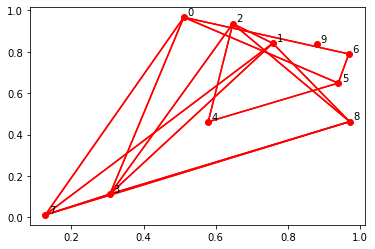

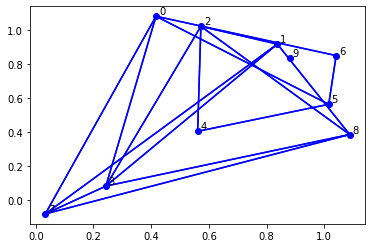

In [8]:
import algos.frankenstein as fs
import algos
from importlib import reload

reload(fs)
reload(algos)
draw(V, adj_V, color='r')
W = fs.frank(V, adj_V, N=5, C0=1, C6=0.005)
draw(W, adj_V)

In [15]:
y_srt = sorted(V, key=(lambda v: v[1]))

sts = 


[array([0.12770832, 0.01137783]), array([0.30689965, 0.11244357]), array([0.57896696, 0.46161658]), array([0.97073891, 0.46228124]), array([0.93908711, 0.64839769]), array([0.96837609, 0.78946608]), array([0.87979952, 0.83564527]), array([0.75790473, 0.84097426]), array([0.64706453, 0.93543573]), array([0.51136334, 0.96677773])]
